# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

C:\Users\Lars M. Angelsen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Lars M. Angelsen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Lars M. Angelsen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Lars M. An

## Configurations

In [2]:
class ShipConfig(Config):
    """Configuration for training on the toy ships dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "ships"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShipConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class ShipDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of crudely generated images of two boats
    The images are generated on the fly. No file access required.
    """

    def load_ships(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("ships", 1, "cruiseship")
        self.add_class("ships", 2, "tanker")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, ships = self.random_image(height, width)
            self.add_image("ships", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, ships=ships)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for ship, dims in info['ships']:
            image = self.draw_ship(image, ship, dims)
        return image

    def image_reference(self, image_id):
        """Return the ships data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "ships":
            return info["ships"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for ships of the given image ID.
        """
        info = self.image_info[image_id]
        ships = info['ships']
        count = len(ships)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (ship, dims) in enumerate(info['ships']):
            mask[:, :, i:i + 1] = self.draw_mask(mask[:, :, i:i + 1].copy(),
                                                  ship, dims)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count - 2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(
                occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in ships])
        return mask, class_ids.astype(np.int32)

    def rotateImage(self, image, angle):
        image_center = tuple(np.array(image.shape[1::-1]) / 2)
        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
        result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
        return result

    def image_resize(self, image, width=None, height=None, inter=cv2.INTER_AREA):
        # initialize the dimensions of the image to be resized and
        # grab the image size
        dim = None
        (h, w) = image.shape[:2]

        # if both the width and height are None, then return the
        # original image
        if width is None and height is None:
            return image

        # check to see if the width is None
        if width is None:
            # calculate the ratio of the height and construct the
            # dimensions
            r = height / float(h)
            dim = (int(w * r), height)

        # otherwise, the height is None
        else:
            # calculate the ratio of the width and construct the
            # dimensions
            r = width / float(w)
            dim = (width, int(h * r))

        # resize the image
        resized = cv2.resize(image, dim, interpolation=inter)

        # return the resized image
        return resized

    def transform(self, ship, dims):

        x, y, s, r, m = dims

        #Scale
        if np.shape(ship[0]) > np.shape(ship[1]):
            ship = self.image_resize(ship.copy(), height=2*s)
        else:
            ship = self.image_resize(ship.copy(), width=2*s)
        #Rotate
        ship = self.rotateImage(ship.copy(),r)
        #Mirror
        if m: ship = cv2.flip(ship.copy(),1)

        return ship

    def draw_ship(self, image, ship, dims):
        """Draws a ship from the given specs."""
        # Get the center x, y and the size s
        x, y, s, r, m = dims

        #Load files
        im_path = ''
        if ship == 'cruiseship':
            im_path = 'ships/cruiseship_isolated.png'
        elif ship == 'tanker':
            im_path = 'ships/tanker_isolated.png'
        

        #Transforming ship
        ship = cv2.imread(im_path)
        ship_transformed = self.transform(ship.copy(), dims)
        
        #print("before", ship_transformed)
        
        ship_shape = np.shape(ship_transformed)
        s_x = int((ship_shape[0])//2)
        s_y = int((ship_shape[1])//2)
        im_s_x = np.shape(image[x-s_x:x+s_x, y-s_y:y+s_y, :])[0]
        im_s_y = np.shape(image[x-s_x:x+s_x, y-s_y:y+s_y, :])[1]
        
        #Slicing to fit if necessary, this is stupid I know...
        if np.shape(ship_transformed)[0] != im_s_x:
            ship_transformed = ship_transformed[0:im_s_x,:]
            
        if np.shape(ship_transformed)[1] != im_s_y:
            ship_transformed = ship_transformed[:,0:im_s_y]
            
        #print("after", ship_transformed)
        #print(s_x,s_y,im_s_x,im_s_y)
        #print(dims)

        ship_transformed_th = self.threshold(ship_transformed.copy())

        #Adding boat to image
        image_slice = image[x - s_x:x + s_x, y - s_y:y + s_y, :]
        image_slice -= 255*image_slice*ship_transformed_th
        image_slice += ship_transformed
        image[x - s_x:x + s_x, y - s_y:y + s_y, :] = image_slice

        return image

    def threshold(self, image):
        image_gs = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
        image_gs = np.expand_dims(image_gs, 2)

        _, image_th = cv2.threshold(image_gs, 10, 255, cv2.THRESH_BINARY)
        image_th = np.expand_dims(image_th, 2)
        return image_th

    def draw_mask(self, image, ship, dims):
        """Draws a mask from the given specs."""
        # Get the center x, y and the size s
        x, y, s, r, m = dims

        #Load files
        ma_path = ''
        if ship == 'cruiseship':
            ma_path = 'ships/cruiseship_isolated_mask.png'
            id = 1
        elif ship == 'tanker':
            ma_path = 'ships/tanker_isolated_mask.png'
            id = 2

        #Transforming mask
        mask = cv2.imread(ma_path)
        mask_transformed = self.transform(mask.copy(), dims)
        mask_shape = np.shape(mask_transformed)
        s_x = int((mask_shape[0]+0.5)//2)
        s_y = int((mask_shape[1]+0.5)//2)
        im_s_x = np.shape(image[x-s_x:x+s_x, y-s_y:y+s_y, :])[0]
        im_s_y = np.shape(image[x-s_x:x+s_x, y-s_y:y+s_y, :])[1]

        #Slicing to fit if necessary, this is stupid I know...
        if np.shape(mask_transformed)[0] != im_s_x:
            mask_transformed = mask_transformed[0:im_s_x,:]
            
        if np.shape(mask_transformed)[1] != im_s_y:
            mask_transformed = mask_transformed[:,0:im_s_y]

        mask_transformed_th = self.threshold(mask_transformed.copy())


        #Adding mask to image
        image[x-s_x:x+s_x, y-s_y:y+s_y, :] = id/255*mask_transformed_th

        return image

    def random_ship(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Ship
        ship = random.choice(["cruiseship", "tanker"])
        # Center x, y
        buffer = 25
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(5, height // 5)
        if s % 2 == 1: s -= 1
        # Rotation
        r = random.randint(-5,5)
        # Mirror
        m = random.randint(0,1)
        return ship, (x, y, s, r, m)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple ships.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color (blueish)
        bg_color = np.array([random.randint(240, 255) for _ in range(3)])
        bg_color[0] = bg_color[0] / 10
        bg_color[1] = bg_color[1] / 10
        # Generate a few random ships and record their
        # bounding boxes
        ships = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, dims = self.random_ship(height, width)
            ships.append((shape, dims))
            x, y, s, _, _ = dims
            boxes.append([y - s, x - s, y + s, x + s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # ships covering each other
        keep_ixs = utils.non_max_suppression(
            np.array(boxes), np.arange(N), 0.3)
        ships = [s for i, s in enumerate(ships) if i in keep_ixs]
        return bg_color, ships

In [5]:
# Training dataset
dataset_train = ShipDataset()
dataset_train.load_ships(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShipDataset()
dataset_val.load_ships(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

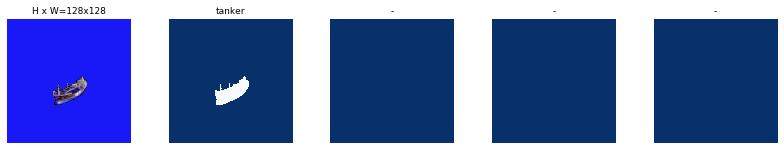

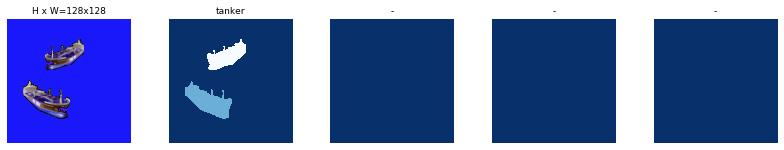

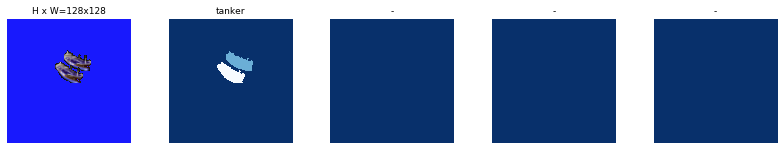

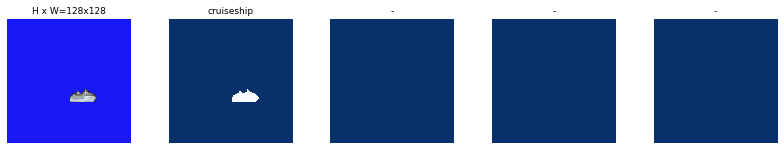

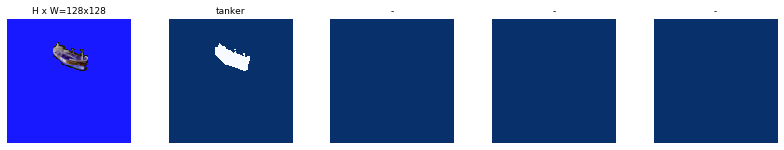

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

model_path = os.path.join(ROOT_DIR+"/logs", "mask_rcnn_ships.h5")
model.load_weights(model_path, by_name=True)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [8]:
# Which weights to start with?
init_with = "none"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)
    
else:
    print("None")

None


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=40, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\Lars M. Angelsen\MaskRCNN\logs\ships20190911T0908\mask_rcnn_ships_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)

C:\Users\Lars M. Angelsen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Lars M. Angelsen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Lars M. Angelsen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "




Epoch 1/40
100/100 [==============================] - 86s 863ms/step - loss: 0.8774 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.5024 - mrcnn_class_loss: 0.0752 - mrcnn_bbox_loss: 0.1185 - mrcnn_mask_loss: 0.1608 - val_loss: 0.5845 - val_rpn_class_loss: 0.0105 - val_rpn_bbox_loss: 0.3075 - val_mrcnn_class_loss: 0.0296 - val_mrcnn_bbox_loss: 0.0839 - val_mrcnn_mask_loss: 0.1531
Epoch 2/40
100/100 [==============================] - 155s 2s/step - loss: 0.5965 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3035 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.0846 - mrcnn_mask_loss: 0.1511 - val_loss: 0.4818 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 0.2530 - val_mrcnn_class_loss: 0.0199 - val_mrcnn_bbox_loss: 0.0671 - val_mrcnn_mask_loss: 0.1328
Epoch 3/40
100/100 [==============================] - 154s 2s/step - loss: 0.4989 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2390 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.1427 - val_loss: 0.4042 - val_rpn_cla

100/100 [==============================] - 75s 752ms/step - loss: 0.1950 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0488 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0955 - val_loss: 0.2933 - val_rpn_class_loss: 0.0037 - val_rpn_bbox_loss: 0.1344 - val_mrcnn_class_loss: 0.0201 - val_mrcnn_bbox_loss: 0.0317 - val_mrcnn_mask_loss: 0.1034
Epoch 22/40
100/100 [==============================] - 75s 746ms/step - loss: 0.1872 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0949 - val_loss: 0.4031 - val_rpn_class_loss: 0.0055 - val_rpn_bbox_loss: 0.1966 - val_mrcnn_class_loss: 0.0278 - val_mrcnn_bbox_loss: 0.0470 - val_mrcnn_mask_loss: 0.1261
Epoch 23/40
100/100 [==============================] - 74s 741ms/step - loss: 0.1876 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0427 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0230 - mrcnn_mask_loss: 0.0970 - val_loss: 0.3085 - val_rpn_class_loss

In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 40. LR=0.0001

Checkpoint Path: C:\Users\Lars M. Angelsen\MaskRCNN\logs\ships20190911T0908\mask_rcnn_ships_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2

C:\Users\Lars M. Angelsen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Lars M. Angelsen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Lars M. Angelsen\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [11]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_ships.h5")
model.keras_model.save_weights(model_path)

## Detection

In [12]:
class InferenceConfig(ShipConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR+"/logs", "mask_rcnn_ships.h5")
#model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  C:\Users\Lars M. Angelsen\MaskRCNN/logs\mask_rcnn_ships.h5


original_image           shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  128.00000  int32
gt_class_id              shape: (4,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (4, 4)                min:   19.00000  max:  100.00000  int32
gt_mask                  shape: (128, 128, 4)         min:    0.00000  max:    2.00000  uint8


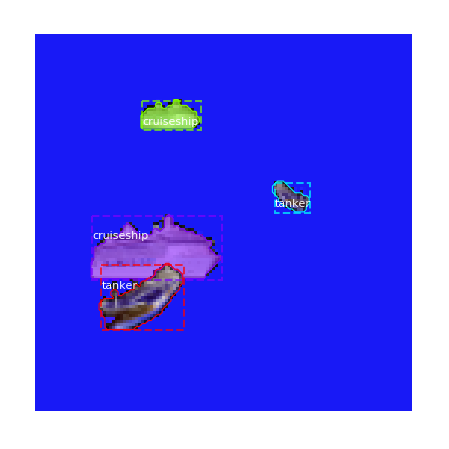

In [23]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


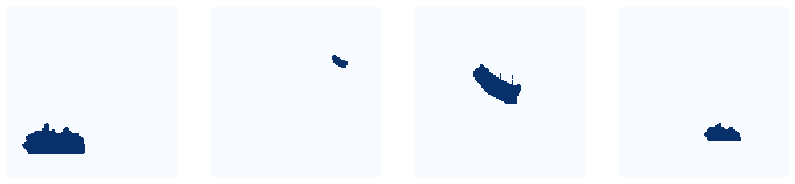

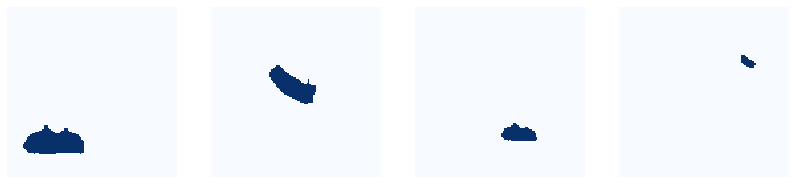

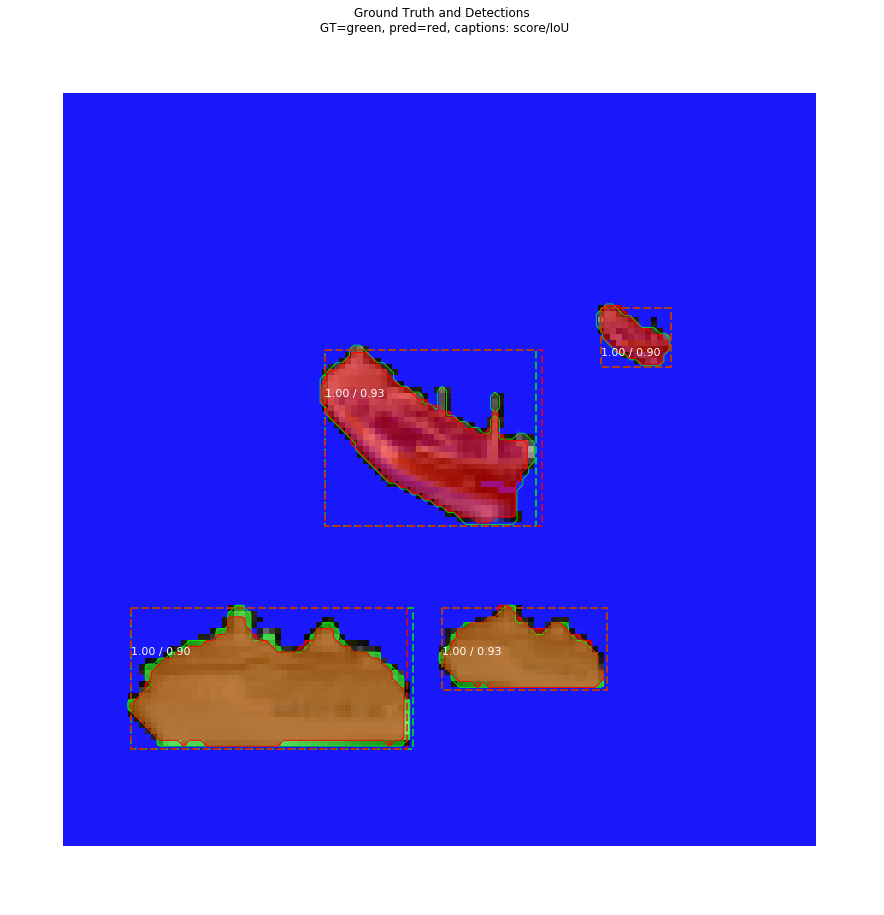

In [41]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

results = model.detect([original_image], verbose=1)
r = results[0]


visualize.display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")
visualize.display_images(np.transpose(r['masks'], [2, 0, 1]), cmap="Blues")

visualize.display_differences(original_image,
                    gt_bbox, gt_class_id, gt_mask,
                    r['rois'], r['class_ids'], r['scores'], r['masks'],
                    dataset_val.class_names, title="", ax=None,
                    show_mask=True, show_box=True,
                    iou_threshold=0.5, score_threshold=0.5)

## Evaluation

In [15]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 40)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  1.0
